# Final Exercice: The Rumos Bank 

The Rumos Bank é um banco que tem perdido bastante dinheiro devido à quantidade de créditos que fornece e que não são pagos dentro do prazo devido. 

    - Por cada cliente que se estima que não irá  pagar dentro do prazo e afinal paga, o banco tem um custo de 1000euros. 

    - Por cada cliente que se prevê como sendo um bom pagador e afinal não paga dentro do prazo, o banco tem um custo de 3000euros.


Vocês, data scientists de topo,  são contratados para ajudar o banco a prever quais os clientes que não irão cumprir os prazos, para que este consiga uma melhor gestão dos fundos.

Conseguem construir um modelo que ajude a detectar previamente e com sucesso os clientes que são maus pagadores?


Dataset: https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset

Variáveis disponíveis:

    ID: ID of each client
    LIMIT_BAL: Amount of given credit in NT dollars (includes individual and family/supplementary credit
    SEX: Gender (1=male, 2=female)
    EDUCATION: (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)
    MARRIAGE: Marital status (1=married, 2=single, 3=others)
    AGE: Age in years
    PAY_0: Repayment status in September, 2005 (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, ... 8=payment delay for eight months, 9=payment delay for nine months and above)
    PAY_2: Repayment status in August, 2005 (scale same as above)
    PAY_3: Repayment status in July, 2005 (scale same as above)
    PAY_4: Repayment status in June, 2005 (scale same as above)
    PAY_5: Repayment status in May, 2005 (scale same as above)
    PAY_6: Repayment status in April, 2005 (scale same as above)
    BILL_AMT1: Amount of bill statement in September, 2005 (NT dollar)
    BILL_AMT2: Amount of bill statement in August, 2005 (NT dollar)
    BILL_AMT3: Amount of bill statement in July, 2005 (NT dollar)
    BILL_AMT4: Amount of bill statement in June, 2005 (NT dollar)
    BILL_AMT5: Amount of bill statement in May, 2005 (NT dollar)
    BILL_AMT6: Amount of bill statement in April, 2005 (NT dollar)
    PAY_AMT1: Amount of previous payment in September, 2005 (NT dollar)
    PAY_AMT2: Amount of previous payment in August, 2005 (NT dollar)
    PAY_AMT3: Amount of previous payment in July, 2005 (NT dollar)
    PAY_AMT4: Amount of previous payment in June, 2005 (NT dollar)
    PAY_AMT5: Amount of previous payment in May, 2005 (NT dollar)
    PAY_AMT6: Amount of previous payment in April, 2005 (NT dollar)
    default.payment.next.month: Default payment (1=yes, 0=no)

#### Perguntas:

    1. Quantas features estão disponíveis? Quantos clientes?
    2. Quantos clientes têm no dataset que efectivamente foram maus pagadores? E quantos não foram?
    3. Qual o modelo que levou a melhores resultados? Qual a métrica usada para comparar os diferentes modelos?
    4. Quais são as features mais relevantes para decidir se um cliente tem mais propensão para ser mau pagador?
    5. Qual seria o custo que o banco tem sem nenhum modelo?
    6. Qual o custo que o banco passa a tar com o vosso modelo?

Com base na informação dada, podemos definir que:

    True positive - Os maus pagadores são identificados correctamente.
    True negative - Os bons pagadores são identificados correctamente.
    False positive - Um bom pagador é identificado como sendo um mau pagador.
    False negative - Um mau pagador é identificado como sendo um bom pagador.

In [1]:
ROOT_PATH = '../data/'
PATH = ROOT_PATH + 'lending_data.csv'
TARGET_COL = 'default.payment.next.month'

SEED = 42

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import  precision_recall_curve, roc_auc_score, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score,auc, roc_curve
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import tree
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier

import mlflow
from mlflow.models import infer_signature



In [3]:
df = pd.read_csv(PATH)

# Definir a diretoria onde as experiências são guardadas

In [ ]:
from pathlib import Path

uri = "../../mlruns"

Path(uri).mkdir(parents=True, exist_ok=True)

mlflow.set_tracking_uri(uri)

# Criar "Experiment"

In [5]:
mlflow.set_experiment("Good Clients Prediction Experiment")

2025/03/31 16:59:41 INFO mlflow.tracking.fluent: Experiment with name 'Good Clients Prediction Experiment' does not exist. Creating a new experiment.


<Experiment: artifact_location='/Users/bernardomatos/Documents/Pos_Graduacao_Data_Science/OML_BM/notebooks/../mlruns/695255423938813665', creation_time=1743436781528, experiment_id='695255423938813665', last_update_time=1743436781528, lifecycle_stage='active', name='Good Clients Prediction Experiment', tags={}>

# EDA

In [6]:
df.shape

(30000, 25)

In [7]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [8]:
df.ID.nunique()

30000

#### 1. Quantas features estão disponíveis? Quantos clientes?

    - Existem 24 features disponíveis no dataset.
    - Existem 30000 clientes.

Existem missing values?

In [9]:
df.isnull().values.any()

np.False_

Existem o mesmo número de clientes nas duas classes?

In [10]:
df.groupby('default.payment.next.month')['default.payment.next.month'].count()

default.payment.next.month
0    23364
1     6636
Name: default.payment.next.month, dtype: int64

Não! O dataset é altamente desequilibrado.

#### 2. Quantos clientes têm no dataset que efectivamente foram maus pagadores? E quantos não foram?

    - 23,364 foram bons pagadores. 6,636 foram maus pagadores.

Existem features não númericas?

In [11]:
df.dtypes

ID                              int64
LIMIT_BAL                     float64
SEX                             int64
EDUCATION                       int64
MARRIAGE                        int64
AGE                             int64
PAY_0                           int64
PAY_2                           int64
PAY_3                           int64
PAY_4                           int64
PAY_5                           int64
PAY_6                           int64
BILL_AMT1                     float64
BILL_AMT2                     float64
BILL_AMT3                     float64
BILL_AMT4                     float64
BILL_AMT5                     float64
BILL_AMT6                     float64
PAY_AMT1                      float64
PAY_AMT2                      float64
PAY_AMT3                      float64
PAY_AMT4                      float64
PAY_AMT5                      float64
PAY_AMT6                      float64
default.payment.next.month      int64
dtype: object

Todas as features são númericas.

Vamos retirar o ID do cliente:

In [12]:
df = df.drop('ID', axis = 1)

Vamos então dividir o dataset em treino e teste:

In [13]:
train_set, test_set = train_test_split(df, test_size = 0.2, random_state = SEED)

In [14]:
X_train = train_set.drop(['default.payment.next.month'], axis = 'columns')
y_train = train_set['default.payment.next.month']

X_test = test_set.drop(['default.payment.next.month'], axis = 1)
y_test = test_set['default.payment.next.month']

Normalização:

In [15]:
scaler = MinMaxScaler()

features_names = X_train.columns

X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns = features_names)

X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test, columns = features_names)

Antes de iniciar, vamos calcular a baseline, ou seja, o custo que temos sem nenhum modelo.

$$totalCost = 1000∗FP+3000∗FN$$

In [16]:
y_preds_all_bad = np.ones(y_test.shape) 

In [17]:
tn, fp, fn, tp = confusion_matrix(y_test, y_preds_all_bad).ravel()

print('Number of True Negatives:', tn)
print('Number of True Positives:', tp)
print('Number of False Negatives:', fn)
print('Number of False Positives:', fp)

Number of True Negatives: 0
Number of True Positives: 1313
Number of False Negatives: 0
Number of False Positives: 4687


In [18]:
print('Total Cost:', fp*1000)

Total Cost: 4687000


In [19]:
accuracy_score(y_test, y_preds_all_bad)

0.21883333333333332

Se todos os clientes fossem considerados como maus pagadores, o banco teria um custo de 4,687,000 Euros.

In [20]:
y_preds_all_good = np.zeros(y_test.shape) 

tn, fp, fn, tp = confusion_matrix(y_test, y_preds_all_good).ravel()

print('Number of True Negatives:', tn)
print('Number of True Positives:', tp)
print('Number of False Negatives:', fn)
print('Number of False Positives:', fp)

Number of True Negatives: 4687
Number of True Positives: 0
Number of False Negatives: 1313
Number of False Positives: 0


In [21]:
print('Total Cost:', fn*3000)

Total Cost: 3939000


In [22]:
accuracy_score(y_test, y_preds_all_good)

0.7811666666666667

Se todos os clientes fossem considerados bons pagadores, o banco teria um custo de 3,939,000 Euros.

In [23]:
def total_cost(y_test, y_preds, threshold = 0.5):
    
    tn, fp, fn, tp = confusion_matrix(y_test == 1, y_preds > threshold).ravel()
    
    cost_fn = fn*3000
    cost_fp = fp*1000
    
    return cost_fn + cost_fp
    

In [24]:
def min_cost_threshold(y_test, y_preds):
    
    costs = {}
    
    for threshold in np.arange(0, 1.1, 0.1):
        
        costs[round(threshold, 1)] = total_cost(y_test, y_preds, threshold = threshold)
        
    plt.plot(list(costs.keys()), list(costs.values()))
    plt.ylabel('Cost')
    plt.xlabel('Threshold')
    plt.show()
    

#### Logistic Regression

In [25]:
run = mlflow.start_run(run_name="Logistic Regression Run")
RUN_ID = run.info.run_uuid
RUN_ID

'5f9004c932e0452a9b10635fe8c3f998'

In [26]:
# guardarmos o dataset de treino e de teste associado à run
train_dataset = mlflow.data.from_pandas(train_set, source=PATH, targets=TARGET_COL, name="Lending Dataset")
test_dataset = mlflow.data.from_pandas(test_set, source=PATH, targets=TARGET_COL, name="Lending Dataset")
mlflow.log_input(train_dataset, context="train")
mlflow.log_input(test_dataset, context="test")

# Guardamos a seed utilizado como parametro
mlflow.log_param("seed", SEED)

signature = infer_signature(X_train, y_train)

/opt/anaconda3/envs/OML_Latest/lib/python3.12/site-packages/mlflow/data/dataset_source_registry.py:149: UserWarning: Failed to determine whether UCVolumeDatasetSource can resolve source information for '../data/lending_data.csv'. Exception: 
  return _dataset_source_registry.resolve(
/opt/anaconda3/envs/OML_Latest/lib/python3.12/site-packages/mlflow/data/dataset_source_registry.py:149: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(
/opt/anaconda3/envs/OML_Latest/lib/python3.12/site-packages/mlflow/data/dataset_source_registry.py:149: UserWarning: Failed to determine whether UCVolumeDatasetSource can resolve source information for '../data/lending_data.csv'. Exception: 
  return _dataset_source_registry.resolve(
/opt/anaconda3/envs/OML_Latest/lib/python3.12/site-packages/mlflow/data/dataset

In [27]:
lr = LogisticRegression(max_iter = 500, solver = 'lbfgs', random_state = SEED, class_weight = 'balanced' )

parameters = {'C':[0.001, 0.01, 0.1, 1, 10, 100]}

clf_lr = GridSearchCV(lr, parameters, cv = 5).fit(X_train, y_train)

In [28]:
clf_lr

GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced', max_iter=500,
                                          random_state=42),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100]})

In [29]:
mlflow.sklearn.log_model(clf_lr.best_estimator_, artifact_path="logistic_reg", registered_model_name="logistic_reg", signature=signature)

params=clf_lr.best_estimator_.get_params()
mlflow.log_params(params)
params

Successfully registered model 'logistic_reg'.
Created version '1' of model 'logistic_reg'.


{'C': 0.1,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 500,
 'multi_class': 'deprecated',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [30]:
y_preds = clf_lr.best_estimator_.predict(X_test)

In [31]:
mlflow.log_metric("accuracy", accuracy_score(y_test, y_preds))
mlflow.log_metric("recall", recall_score(y_test, y_preds))
mlflow.log_metric("precision", precision_score(y_test, y_preds))
mlflow.log_metric("f1", f1_score(y_test, y_preds))
mlflow.log_metric("roc_auc", roc_auc_score(y_test, y_preds))
mlflow.log_metric("total_cost", total_cost(y_test, y_preds, threshold = 0.5))


In [32]:
mlflow.end_run()

In [33]:
y_preds = clf_lr.predict_proba(X_test)[:,1]

In [34]:
total_cost(y_test, y_preds, threshold = 0.5)

np.int64(2852000)

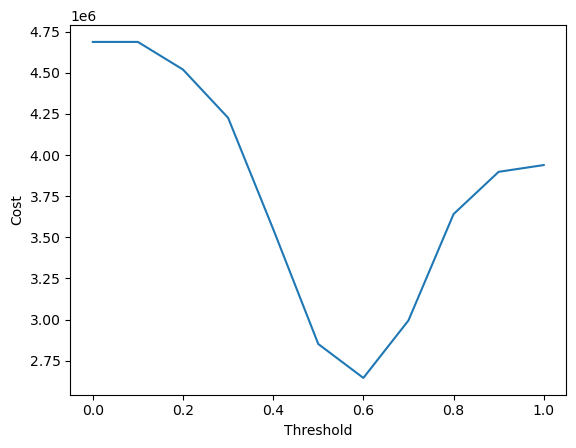

In [35]:
min_cost_threshold(y_test, y_preds)

In [36]:
total_cost(y_test, y_preds, threshold = 0.6)

np.int64(2646000)

O Custo é minimo para um threshold de 0.6: 2,646,000 Euros, que é a melhor que a baseline!

#### KNN

In [37]:
run = mlflow.start_run(run_name="KNN Run")
RUN_ID = run.info.run_uuid
RUN_ID

'77ef1de31be94f35965011f4e61f3751'

In [38]:
# guardarmos o dataset de treino e de teste associado à run
mlflow.log_input(train_dataset, context="train")
mlflow.log_input(test_dataset, context="test")

# Guardamos a seed utilizado como parametro
mlflow.log_param("seed", SEED)

signature = infer_signature(X_train, y_train)

/opt/anaconda3/envs/OML_Latest/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


In [39]:
knn = KNeighborsClassifier()

parameters = {'n_neighbors': range(1,10, 1)}

clf_knn = GridSearchCV(knn, parameters, cv = 5).fit(X_train, y_train)

In [40]:
mlflow.sklearn.log_model(clf_knn.best_estimator_, artifact_path="knn", registered_model_name="knn", signature=signature)

params=clf_knn.best_estimator_.get_params()
mlflow.log_params(params)
params

Successfully registered model 'knn'.
Created version '1' of model 'knn'.


{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 9,
 'p': 2,
 'weights': 'uniform'}

In [41]:
y_preds = clf_knn.best_estimator_.predict(X_test)

In [42]:
mlflow.log_metric("accuracy", accuracy_score(y_test, y_preds))
mlflow.log_metric("recall", recall_score(y_test, y_preds))
mlflow.log_metric("precision", precision_score(y_test, y_preds))
mlflow.log_metric("f1", f1_score(y_test, y_preds))
mlflow.log_metric("roc_auc", roc_auc_score(y_test, y_preds))
mlflow.log_metric("total_cost", total_cost(y_test, y_preds))


In [43]:
mlflow.end_run()

KNN não é um metodo adequado para grandes datasets! Vamos ver se compensa a nível de resultados:

In [44]:
y_preds = clf_knn.predict_proba(X_test)[:,1]

clf_knn.score(X_test, y_test)

0.807

In [45]:
total_cost(y_test, y_preds, threshold = 0.5)

np.int64(2900000)

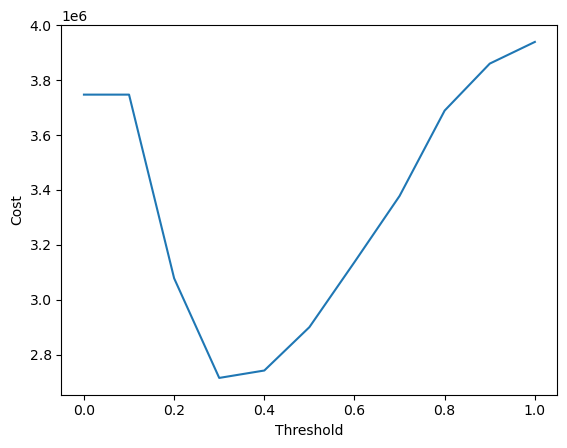

In [46]:
min_cost_threshold(y_test, y_preds)

In [47]:
total_cost(y_test, y_preds, threshold = 0.3)

np.int64(2715000)

Melhor que a baseline mas pior que usar regressão logistica.

#### SVM

In [48]:
run = mlflow.start_run(run_name="SVM Run")
RUN_ID = run.info.run_uuid
RUN_ID

'b4e7688d536c4f8badcf3ab6ba3f8b90'

In [49]:
# guardarmos o dataset de treino e de teste associado à run
mlflow.log_input(train_dataset, context="train")
mlflow.log_input(test_dataset, context="test")

# Guardamos a seed utilizado como parametro
mlflow.log_param("seed", SEED)

signature = infer_signature(X_train, y_train)

/opt/anaconda3/envs/OML_Latest/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


In [50]:
svc = SVC(random_state = SEED, class_weight = 'balanced', gamma = 'scale', probability = True, verbose = True)

parameters = {'C':[0.1, 1, 10], 'kernel': ('rbf', 'linear') }

clf_svc = GridSearchCV(svc, parameters, cv = 5).fit(X_train, y_train)

[LibSVM].............
*
optimization finished, #iter = 13751
obj = -1079.975659, rho = -1.571294
nSV = 11227, nBSV = 8898
Total nSV = 11227
.............
*
optimization finished, #iter = 13602
obj = -1074.923463, rho = -1.831821
nSV = 11178, nBSV = 8899
Total nSV = 11178
.............
*.
*
optimization finished, #iter = 13753
obj = -1078.734402, rho = -1.491745
nSV = 11219, nBSV = 8954
Total nSV = 11219
.............
*
optimization finished, #iter = 13621
obj = -1077.725906, rho = -1.650705
nSV = 11191, nBSV = 8911
Total nSV = 11191
.............
*.
*
optimization finished, #iter = 13726
obj = -1067.545571, rho = -1.682148
nSV = 11125, nBSV = 8876
Total nSV = 11125
...............
*.
*
optimization finished, #iter = 16065
obj = -1335.579355, rho = 1.717018
nSV = 13857, nBSV = 10643
Total nSV = 13857
[LibSVM].............
**.*
optimization finished, #iter = 13584
obj = -1079.589203, rho = -1.655950
nSV = 11230, nBSV = 8952
Total nSV = 11230
.............
**.*
optimization finished, #ite

In [51]:
mlflow.sklearn.log_model(clf_svc.best_estimator_, artifact_path="svc", registered_model_name="svc", signature=signature)

params=clf_svc.best_estimator_.get_params()
mlflow.log_params(params)
params

Successfully registered model 'svc'.
Created version '1' of model 'svc'.


{'C': 0.1,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': 'balanced',
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': True,
 'random_state': 42,
 'shrinking': True,
 'tol': 0.001,
 'verbose': True}

In [52]:
y_preds = clf_svc.best_estimator_.predict(X_test)

In [53]:
mlflow.log_metric("accuracy", accuracy_score(y_test, y_preds))
mlflow.log_metric("recall", recall_score(y_test, y_preds))
mlflow.log_metric("precision", precision_score(y_test, y_preds))
mlflow.log_metric("f1", f1_score(y_test, y_preds))
mlflow.log_metric("roc_auc", roc_auc_score(y_test, y_preds))
mlflow.log_metric("total_cost", total_cost(y_test, y_preds))

In [54]:
mlflow.end_run()

In [55]:
y_preds = clf_svc.predict_proba(X_test)[:,1]

In [56]:
clf_svc.score(X_test, y_test)

0.7778333333333334

In [57]:
total_cost(y_test, y_preds, threshold = 0.5)

np.int64(2933000)

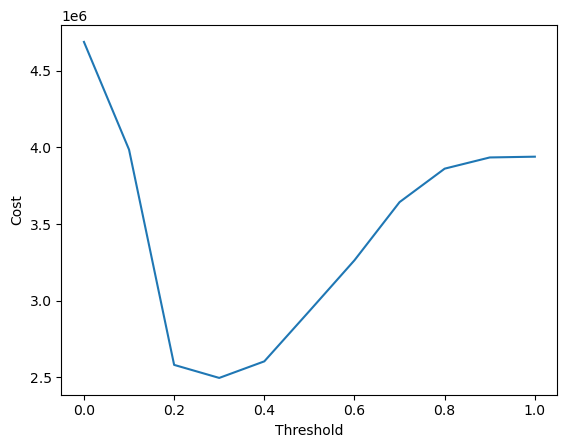

In [58]:
min_cost_threshold(y_test, y_preds)

In [59]:
total_cost(y_test, y_preds, threshold = 0.3)

np.int64(2497000)

Melhor valor até agora!

#### Decision Trees

In [60]:
run = mlflow.start_run(run_name="Decision Tree Run")
RUN_ID = run.info.run_uuid
RUN_ID

'1b64bc4f42d64f3b80c26b6b141ca12e'

In [61]:
# guardarmos o dataset de treino e de teste associado à run
mlflow.log_input(train_dataset, context="train")
mlflow.log_input(test_dataset, context="test")

# Guardamos a seed utilizado como parametro
mlflow.log_param("seed", SEED)

signature = infer_signature(X_train, y_train)

/opt/anaconda3/envs/OML_Latest/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


In [62]:
trees = tree.DecisionTreeClassifier(random_state = SEED,  class_weight = 'balanced')

parameters = {'max_depth':[3, 6], 'min_samples_split': [2, 4, 10]}

clf_tree = GridSearchCV(trees, parameters, cv = 5).fit(X_train, y_train)

In [63]:
clf_tree.best_estimator_

DecisionTreeClassifier(class_weight='balanced', max_depth=3, random_state=42)

In [64]:
mlflow.sklearn.log_model(clf_tree.best_estimator_, artifact_path="tree", registered_model_name="tree", signature=signature)

params=clf_tree.best_estimator_.get_params()
mlflow.log_params(params)
params

Successfully registered model 'tree'.
Created version '1' of model 'tree'.


{'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': 42,
 'splitter': 'best'}

In [65]:
y_preds = clf_tree.best_estimator_.predict(X_test)

In [66]:
mlflow.log_metric("accuracy", accuracy_score(y_test, y_preds))
mlflow.log_metric("recall", recall_score(y_test, y_preds))
mlflow.log_metric("precision", precision_score(y_test, y_preds))
mlflow.log_metric("f1", f1_score(y_test, y_preds))
mlflow.log_metric("roc_auc", roc_auc_score(y_test, y_preds))
mlflow.log_metric("total_cost", total_cost(y_test, y_preds))

In [67]:
mlflow.end_run()

In [68]:
y_preds = clf_tree.predict_proba(X_test)[:,1]

clf_tree.score(X_test, y_test)

0.7608333333333334

In [69]:
total_cost(y_test, y_preds, threshold = 0.5)

np.int64(2581000)

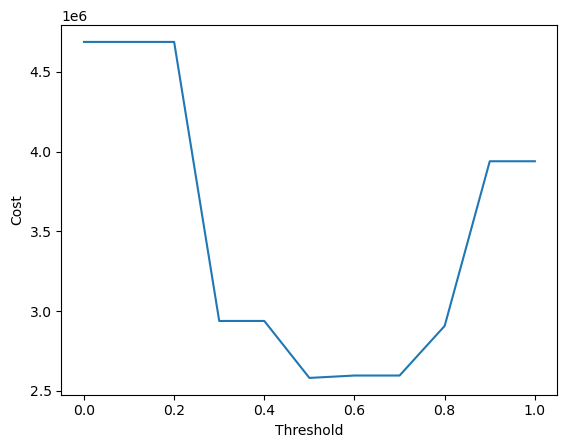

In [70]:
min_cost_threshold(y_test, y_preds)

In [71]:
total_cost(y_test, y_preds, threshold = 0.5)

np.int64(2581000)

SVMs continuam a ganhar.

#### Random Forests

In [72]:
run = mlflow.start_run(run_name="Random Forest Run")
RUN_ID = run.info.run_uuid
RUN_ID

'8454cd563dd1438087395edf36bd247b'

In [73]:
# guardarmos o dataset de treino e de teste associado à run
mlflow.log_input(train_dataset, context="train")
mlflow.log_input(test_dataset, context="test")

# Guardamos a seed utilizado como parametro
mlflow.log_param("seed", SEED)

signature = infer_signature(X_train, y_train)

/opt/anaconda3/envs/OML_Latest/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


In [74]:
rf = RandomForestClassifier(random_state = SEED,  class_weight = 'balanced').fit(X_train, y_train)

parameters = {'n_estimators':[10, 100, 300, 1000]}

clf_rf = GridSearchCV(rf, parameters, cv = 5).fit(X_train, y_train)

In [75]:
mlflow.sklearn.log_model(clf_rf.best_estimator_, artifact_path="random_forest", registered_model_name="random_forest", signature=signature)

params=clf_rf.best_estimator_.get_params()
mlflow.log_params(params)
params

Successfully registered model 'random_forest'.
Created version '1' of model 'random_forest'.


{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 300,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [76]:
y_preds = clf_rf.best_estimator_.predict(X_test)

In [77]:
mlflow.log_metric("accuracy", accuracy_score(y_test, y_preds))
mlflow.log_metric("recall", recall_score(y_test, y_preds))
mlflow.log_metric("precision", precision_score(y_test, y_preds))
mlflow.log_metric("f1", f1_score(y_test, y_preds))
mlflow.log_metric("roc_auc", roc_auc_score(y_test, y_preds))
mlflow.log_metric("total_cost", total_cost(y_test, y_preds))

In [78]:
mlflow.end_run()

In [79]:
y_preds = clf_rf.predict_proba(X_test)[:,1]

clf_rf.score(X_test, y_test)

0.814

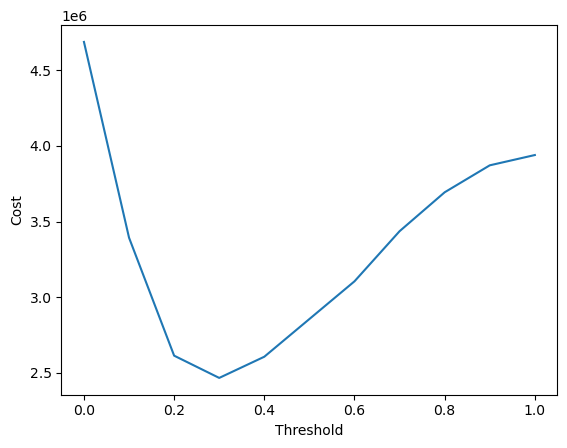

In [80]:
min_cost_threshold(y_test, y_preds)

In [81]:
total_cost(y_test, y_preds, threshold = 0.3)

np.int64(2467000)

Melhor resultado até agora!

#### Neural Networks

In [82]:
run = mlflow.start_run(run_name="Neural Networks Run")
RUN_ID = run.info.run_uuid
RUN_ID

'034ac2448bde46b194c8abdd8a34de02'

In [83]:
# guardarmos o dataset de treino e de teste associado à run
mlflow.log_input(train_dataset, context="train")
mlflow.log_input(test_dataset, context="test")

# Guardamos a seed utilizado como parametro
mlflow.log_param("seed", SEED)

signature = infer_signature(X_train, y_train)

/opt/anaconda3/envs/OML_Latest/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


In [84]:
X_train.shape

(24000, 23)

In [85]:
mlp = MLPClassifier(solver = 'lbfgs',  random_state = SEED, max_iter = 1000 )

parameters = {'hidden_layer_sizes': [(20,), (20,10), (20, 10, 2)], 'learning_rate_init':[0.0001, 0.001, 0.01, 0.1]}

clf_mlp = GridSearchCV(mlp, parameters, cv = 5).fit(X_train, y_train)

/opt/anaconda3/envs/OML_Latest/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/anaconda3/envs/OML_Latest/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/anaconda3/envs/OML_Latest/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs fa

In [86]:
clf_mlp.best_estimator_

MLPClassifier(hidden_layer_sizes=(20,), learning_rate_init=0.0001,
              max_iter=1000, random_state=42, solver='lbfgs')

In [87]:
clf_mlp.best_score_

np.float64(0.8176249999999999)

In [88]:
mlflow.sklearn.log_model(clf_mlp.best_estimator_, artifact_path="neural_networks", registered_model_name="neural_networks", signature=signature)

params=clf_mlp.best_estimator_.get_params()
mlflow.log_params(params)
params

Successfully registered model 'neural_networks'.
Created version '1' of model 'neural_networks'.


{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (20,),
 'learning_rate': 'constant',
 'learning_rate_init': 0.0001,
 'max_fun': 15000,
 'max_iter': 1000,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': 42,
 'shuffle': True,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

In [89]:
y_preds = clf_mlp.best_estimator_.predict(X_test)

In [90]:
mlflow.log_metric("accuracy", accuracy_score(y_test, y_preds))
mlflow.log_metric("recall", recall_score(y_test, y_preds))
mlflow.log_metric("precision", precision_score(y_test, y_preds))
mlflow.log_metric("f1", f1_score(y_test, y_preds))
mlflow.log_metric("roc_auc", roc_auc_score(y_test, y_preds))
mlflow.log_metric("total_cost", total_cost(y_test, y_preds))

In [91]:
mlflow.end_run()

In [92]:
y_preds = clf_mlp.predict_proba(X_test)[:,1]

clf_mlp.score(X_test, y_test)


0.818

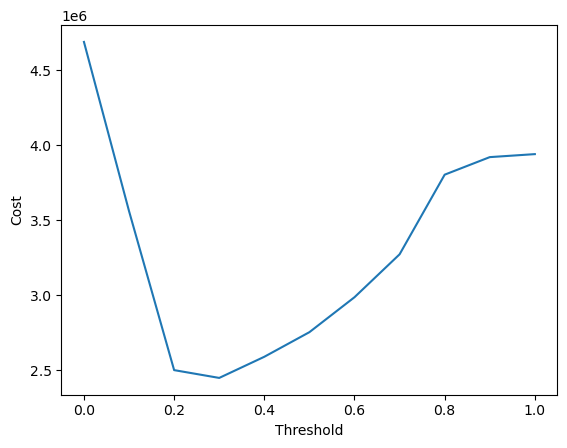

In [93]:
min_cost_threshold(y_test, y_preds)

In [94]:
total_cost(y_test, y_preds, threshold = 0.2)

np.int64(2499000)

Resultado quase igual às random forests!

#### 3. Qual o modelo que levou a melhores resultados? Qual a métrica usada para comparar os diferentes modelos?

- A métrica usada foi o custo total uma vez que o objetivo do modelo era diminuir os custos do banco. O Modelo que levou a melhores resultados foram as neural networks e as random forests - 2,467,000 de custo.  
- Visto que com as neural networks não consigo saber qual a importancia das features, vou eleger o modelo de random forests como a solução final. Para além disso o treino das neural networks demorou quase o dobro do tempo.

#### 4. Quais são as features mais relevantes para decidir se um cliente tem mais propensão para ser mau pagador?

In [95]:
rf = RandomForestClassifier(**clf_rf.best_params_).fit(X_train, y_train)

In [96]:
important_features = pd.DataFrame(data = rf.feature_importances_, index = X_train.columns, columns = ['value'])
important_features.sort_values(by = 'value', ascending = False)

,value
PAY_0,0.096267
AGE,0.066343
BILL_AMT1,0.059944
LIMIT_BAL,0.059747
BILL_AMT2,0.053863
BILL_AMT3,0.051711
PAY_AMT1,0.050584
BILL_AMT6,0.050216
BILL_AMT4,0.050046
BILL_AMT5,0.049804


As variaveis que mais contribuem para o modelo decidir se um cliente vai ser um bom ou mau pagador são:
    - PAY_0 - Repayment status in September, 2005 
    - e AGE - idade do cliente
    

#### 5. Qual seria o custo que o banco tem sem nenhum modelo?

    - O custo que o banco teria sem modelo, ou seja, assumindo que todos os clientes seriam bons pagadores, é de: 3,939,000 Euros.

#### 6. Qual o custo que o banco passa a tar com o vosso modelo?

- O custo que o banco teria com o modelo seria de: 2,476,000 Euros - Pouparia quase 1 Milhão e meio de Euros!